<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/Prediccion_Antawasi_rainfall_Rev5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install contextily pyproj openpyxl pytz

/tmp/ipython-input-184033022.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dict_factores = comp.groupby('mes').apply(lambda x: x['Estacion'].sum() / x['Modelo_Original'].sum()).to_dict()


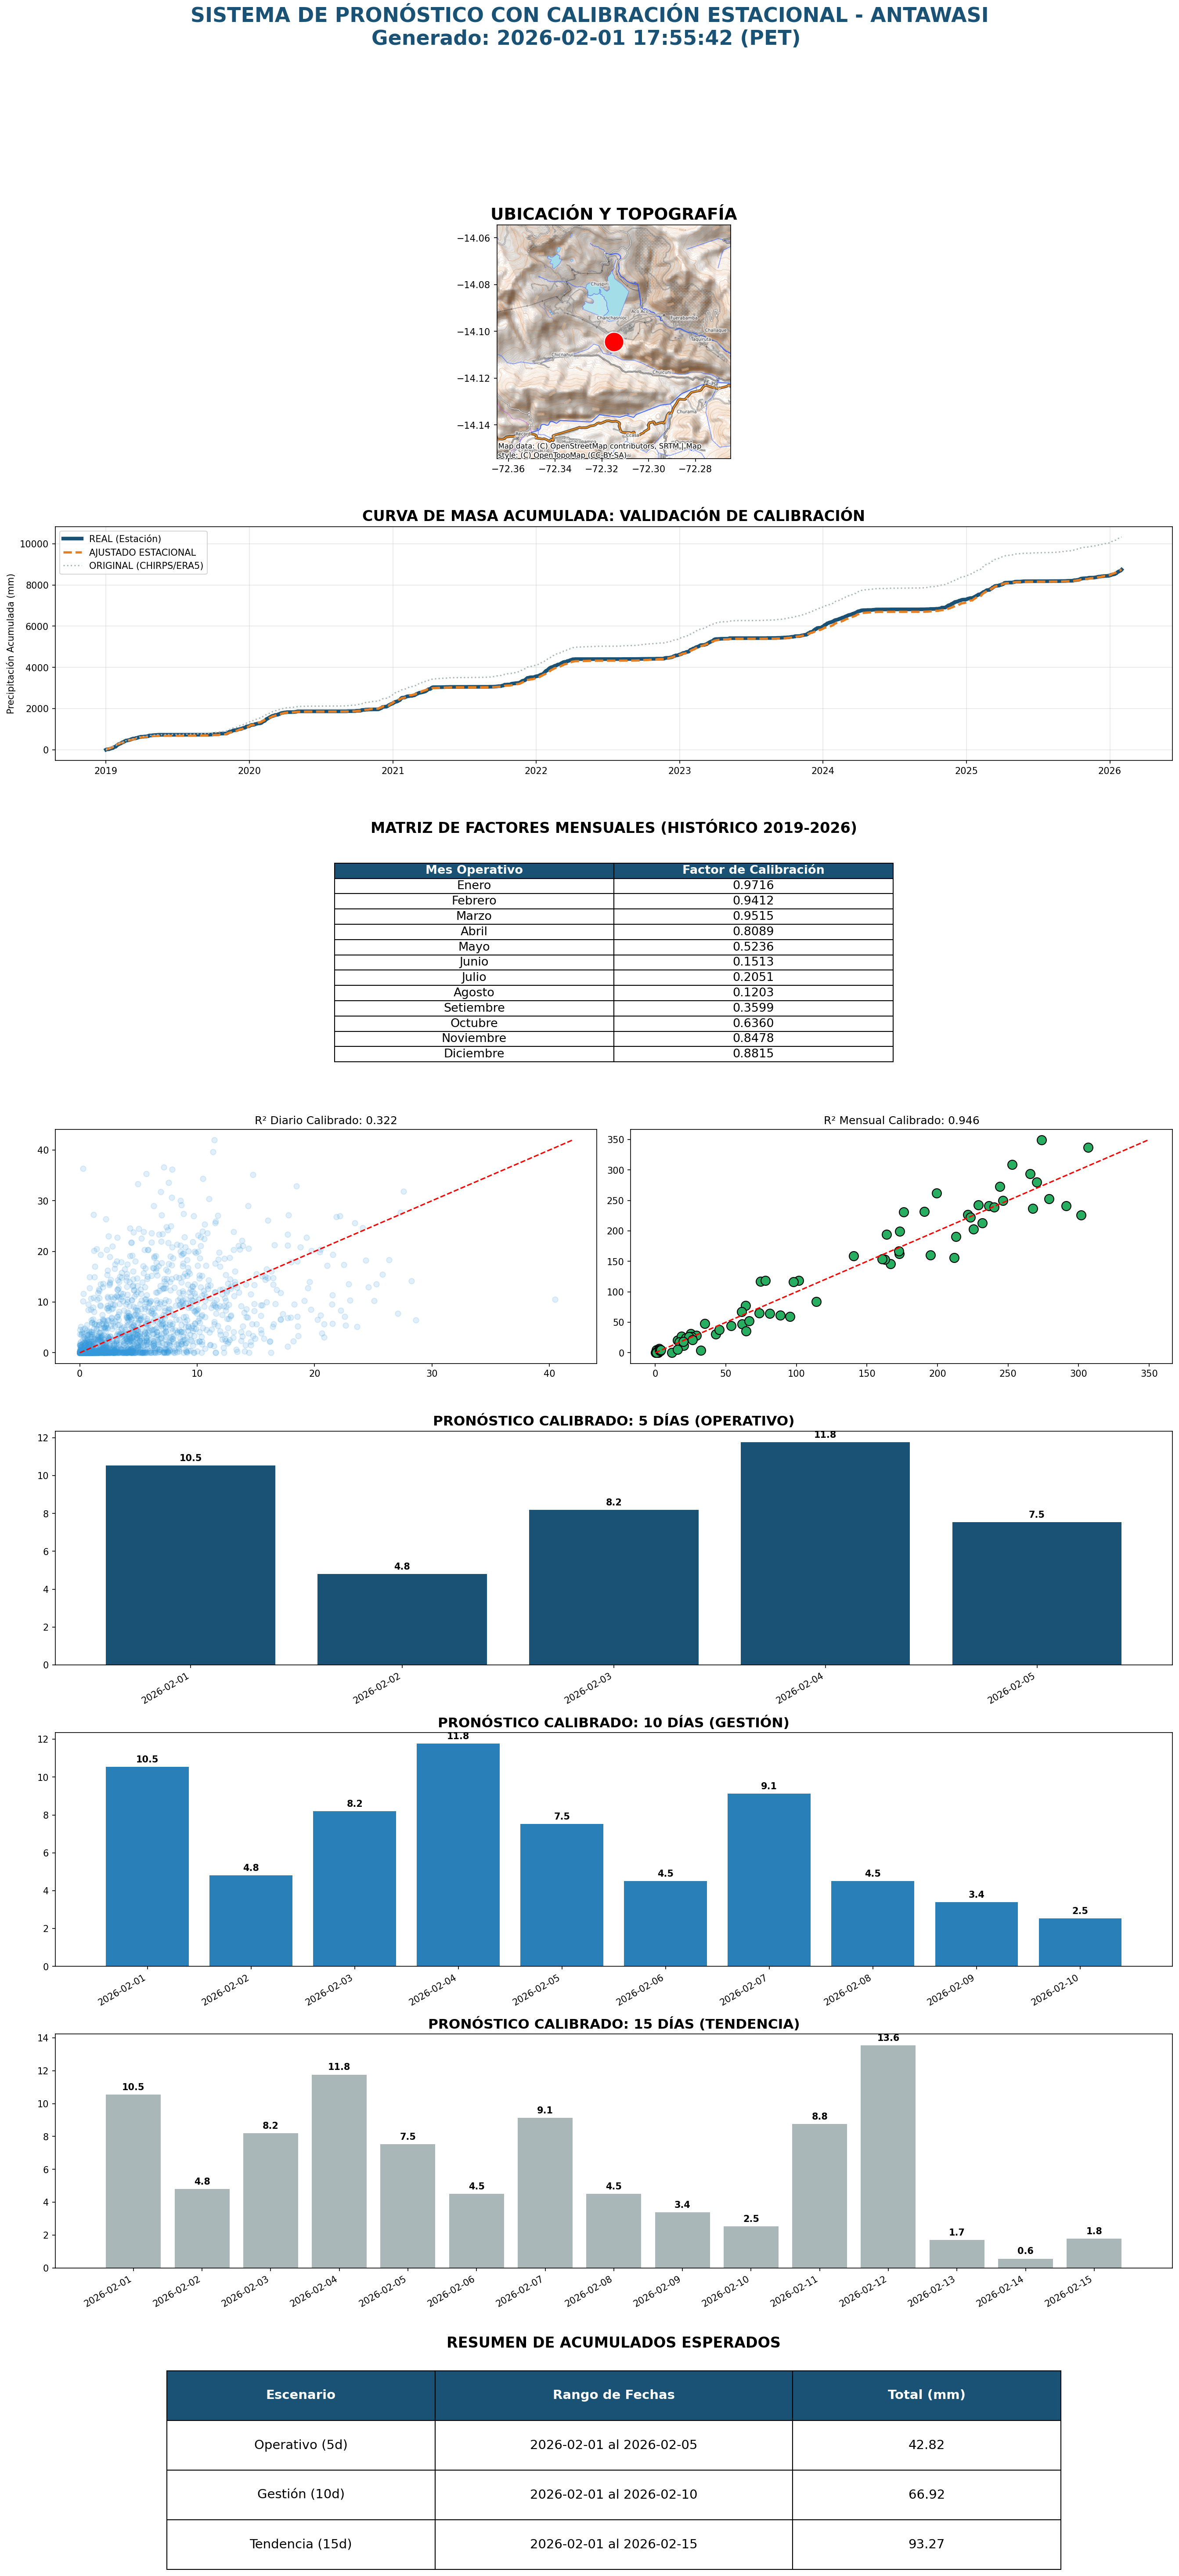

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
import contextily as cx
from sklearn.metrics import r2_score
from datetime import datetime
import pytz

# --- 1. CONFIGURACIÓN DE TIEMPO Y UBICACIÓN ---
tz_peru = pytz.timezone('America/Lima')
ahora_peru_dt = datetime.now(tz_peru)
AHORA_STR = ahora_peru_dt.strftime('%Y-%m-%d %H:%M:%S')
fecha_hoy = ahora_peru_dt.date()

FILE_NAME = 'ANTAWASI.xlsx'
LAT, LON = -14.1045, -72.3149

def obtener_datos(lat, lon, inicio, fin, es_forecast=False):
    tipo = "forecast" if es_forecast else "archive"
    base_url = f"https://api.open-meteo.com/v1/{tipo}" if es_forecast else f"https://archive-api.open-meteo.com/v1/archive"
    params = f"?latitude={lat}&longitude={lon}&hourly=precipitation&timezone=America%2FLima"
    if es_forecast: params += "&forecast_days=15"
    else: params += f"&start_date={inicio}&end_date={fin}"

    r = requests.get(base_url + params).json()
    df = pd.DataFrame({'f': pd.to_datetime(r['hourly']['time']), 'v': r['hourly']['precipitation']})
    df['f_op'] = df['f'] - pd.Timedelta(hours=7)
    return df.groupby(df['f_op'].dt.date)['v'].sum()

try:
    # --- 2. PROCESAMIENTO E HISTÓRICO ---
    df_ex = pd.read_excel(FILE_NAME, header=None, names=['fecha', 'valor'])
    df_ex['fecha'] = pd.to_datetime(df_ex['fecha']).dt.date
    estacion = df_ex.groupby('fecha')['valor'].sum()

    f_ini, f_fin = estacion.index.min().strftime('%Y-%m-%d'), estacion.index.max().strftime('%Y-%m-%d')
    modelo_raw = obtener_datos(LAT, LON, f_ini, f_fin)

    comp = pd.concat([estacion, modelo_raw], axis=1).dropna()
    comp.columns = ['Estacion', 'Modelo_Original']
    comp.index = pd.to_datetime(comp.index)

    # --- 3. CÁLCULO DE 12 FACTORES ESTACIONALES ---
    comp['mes'] = comp.index.month
    dict_factores = comp.groupby('mes').apply(lambda x: x['Estacion'].sum() / x['Modelo_Original'].sum()).to_dict()
    comp['Factor_Mes'] = comp['mes'].map(dict_factores)
    comp['Modelo_Ajustado'] = comp['Modelo_Original'] * comp['Factor_Mes']

    # --- 4. PRONÓSTICO CALIBRADO ---
    pred_full = obtener_datos(LAT, LON, None, None, es_forecast=True)
    pred_raw = pred_full[pred_full.index >= fecha_hoy]
    pred_calib = pred_raw.copy()
    for fecha in pred_calib.index:
        pred_calib.loc[fecha] = pred_raw.loc[fecha] * dict_factores.get(fecha.month, 1.0)

    # --- 5. PANEL DE CONTROL INTEGRAL ---
    fig = plt.figure(figsize=(18, 70))
    gs = fig.add_gridspec(14, 2)
    fig.suptitle(f"SISTEMA DE PRONÓSTICO CON CALIBRACIÓN ESTACIONAL - ANTAWASI\nGenerado: {AHORA_STR} (PET) ",
                 fontsize=22, fontweight='bold', y=0.98, color='#1a5276')

    # 5.1 MAPA 1:1
    ax0 = fig.add_subplot(gs[0, :])
    ax0.scatter([LON], [LAT], color='red', s=450, edgecolors='white', zorder=10)
    delta = 0.05
    ax0.set_xlim(LON - delta, LON + delta); ax0.set_ylim(LAT - delta, LAT + delta)
    ax0.set_aspect('equal')
    cx.add_basemap(ax0, crs='EPSG:4326', source=cx.providers.OpenTopoMap, zoom=13)
    ax0.set_title("UBICACIÓN Y TOPOGRAFÍA", fontsize=18, fontweight='bold')

    # 5.2 CURVA DE MASA (CORREGIDA)
    ax1 = fig.add_subplot(gs[1, :])
    ax1.plot(comp.index, comp['Estacion'].cumsum(), label='REAL (Estación)', color='#1a5276', lw=4)
    ax1.plot(comp.index, comp['Modelo_Ajustado'].cumsum(), label='AJUSTADO ESTACIONAL', color='#e67e22', ls='--', lw=2.5)
    ax1.plot(comp.index, comp['Modelo_Original'].cumsum(), label='ORIGINAL (CHIRPS/ERA5)', color='#aab7b8', ls=':', lw=1.5)
    ax1.set_title('CURVA DE MASA ACUMULADA: VALIDACIÓN DE CALIBRACIÓN', fontsize=16, fontweight='bold')
    ax1.set_ylabel("Precipitación Acumulada (mm)")
    ax1.legend(loc='upper left'); ax1.grid(True, alpha=0.3)

    # 5.3 TABLA DE FACTORES (SIN TRASLAPE)
    ax_ft = fig.add_subplot(gs[2, :])
    ax_ft.axis('off')
    meses_n = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Setiembre", "Octubre", "Noviembre", "Diciembre"]
    data_f = [[meses_n[i], f"{dict_factores.get(i+1, 1.0):.4f}"] for i in range(12)]
    tabla_f = ax_ft.table(cellText=data_f, colLabels=['Mes Operativo', 'Factor de Calibración'], loc='center', cellLoc='center', colWidths=[0.25, 0.25], bbox=[0.25, 0, 0.5, 0.85])
    tabla_f.auto_set_font_size(False); tabla_f.set_fontsize(13)
    for (r, c), cell in tabla_f.get_celld().items():
        if r == 0: cell.set_facecolor('#1a5276'); cell.set_text_props(color='white', weight='bold')
    ax_ft.text(0.5, 0.98, "MATRIZ DE FACTORES MENSUALES (HISTÓRICO 2019-2026)", fontsize=16, fontweight='bold', ha='center', transform=ax_ft.transAxes)

    # 5.4 SCATTER PLOTS
    ax2 = fig.add_subplot(gs[3, 0]); ax2.scatter(comp['Modelo_Ajustado'], comp['Estacion'], alpha=0.15, color='#3498db')
    ax2.plot([0, comp['Estacion'].max()], [0, comp['Estacion'].max()], 'r--')
    ax2.set_title(f'R² Diario Calibrado: {r2_score(comp["Estacion"], comp["Modelo_Ajustado"]):.3f}')

    ax3 = fig.add_subplot(gs[3, 1]); comp_m = comp[['Estacion', 'Modelo_Ajustado']].resample('ME').sum()
    ax3.scatter(comp_m['Modelo_Ajustado'], comp_m['Estacion'], color='#27ae60', s=100, edgecolors='k')
    ax3.plot([0, comp_m['Estacion'].max()], [0, comp_m['Estacion'].max()], 'r--')
    ax3.set_title(f'R² Mensual Calibrado: {r2_score(comp_m["Estacion"], comp_m["Modelo_Ajustado"]):.3f}')

    # 5.5 PRONÓSTICOS
    def autolabel(ax, rects):
        for rect in rects:
            h = rect.get_height()
            if h > 0: ax.annotate(f'{h:.1f}', xy=(rect.get_x() + rect.get_width()/2, h), xytext=(0, 5), textcoords="offset points", ha='center', fontweight='bold')

    bars_info = [(pred_calib.iloc[:5], '5 DÍAS (OPERATIVO)', '#1a5276'), (pred_calib.iloc[:10], '10 DÍAS (GESTIÓN)', '#2980b9'), (pred_calib, '15 DÍAS (TENDENCIA)', '#aab7b8')]
    for i, (data, tit, col) in enumerate(bars_info):
        ax = fig.add_subplot(gs[4+i, :]); bars = ax.bar(data.index.astype(str), data.values, color=col)
        ax.set_title(f'PRONÓSTICO CALIBRADO: {tit}', fontweight='bold', fontsize=15)
        autolabel(ax, bars); plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    # 5.6 TABLA RESUMEN (SIN TRASLAPE)
    ax_t = fig.add_subplot(gs[7, :]); ax_t.axis('off')
    res = [['Escenario', 'Rango de Fechas', 'Total (mm)'], ['Operativo (5d)', f"{pred_calib.index[0]} al {pred_calib.index[4]}", f"{pred_calib.iloc[:5].sum():.2f}"], ['Gestión (10d)', f"{pred_calib.index[0]} al {pred_calib.index[9]}", f"{pred_calib.iloc[:10].sum():.2f}"], ['Tendencia (15d)', f"{pred_calib.index[0]} al {pred_calib.index[-1]}", f"{pred_calib.sum():.2f}"]]
    tab_res = ax_t.table(cellText=res, loc='center', cellLoc='center', colWidths=[0.3, 0.4, 0.3], bbox=[0.1, 0, 0.8, 0.85])
    tab_res.auto_set_font_size(False); tab_res.set_fontsize(14)
    for (r, c), cell in tab_res.get_celld().items():
        if r == 0: cell.set_facecolor('#1a5276'); cell.set_text_props(color='white', weight='bold')
    ax_t.text(0.5, 0.95, "RESUMEN DE ACUMULADOS ESPERADOS", fontsize=16, fontweight='bold', ha='center', transform=ax_t.transAxes)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except Exception as e:
    print(f"Error: {e}")

🛠️ Estructura del Modelo
Fuente de Datos de Predicción: Modelos climáticos globales GFS (Global Forecasting System) y ECMWF (European Centre for Medium-Range Weather Forecasts) procesados a través de la API de Open-Meteo.

Referencia Histórica (Reanálisis): Datos de alta resolución ERA5 y productos satelitales CHIRPS (Climate Hazards Group InfraRed Precipitation with Station data).

Metodología de Calibración: Aplicación de técnica de Bias-Adjustment (Ajuste de Sesgo) mediante factores estacionales mensuales dinámicos.

Base de Calibración: El modelo se sincroniza en tiempo real con los registros históricos de la Estación Antawasi (2019-2026), corrigiendo la subestimación o sobrestimación típica de los sensores satelitales en la zona.

Corte Operativo: Los datos se procesan en hora local (PET), considerando el día hidrológico con cierre a las 07:00 hrs.

⚠️ Descargo de Responsabilidad (Disclaimer)
NOTA OPERATIVA: Este reporte es una herramienta de apoyo a la toma de decisiones y se basa en modelos probabilísticos y estadísticos. La precipitación real puede variar significativamente debido a fenómenos locales de convección (tormentas aisladas) que pueden no ser detectados por modelos de escala global.

El usuario asume toda la responsabilidad por las decisiones operativas, de seguridad o logísticas derivadas de la interpretación de esta información. No se garantiza la exactitud absoluta, especialmente en eventos extremos de muy corto plazo o variaciones microclimáticas súbitas.

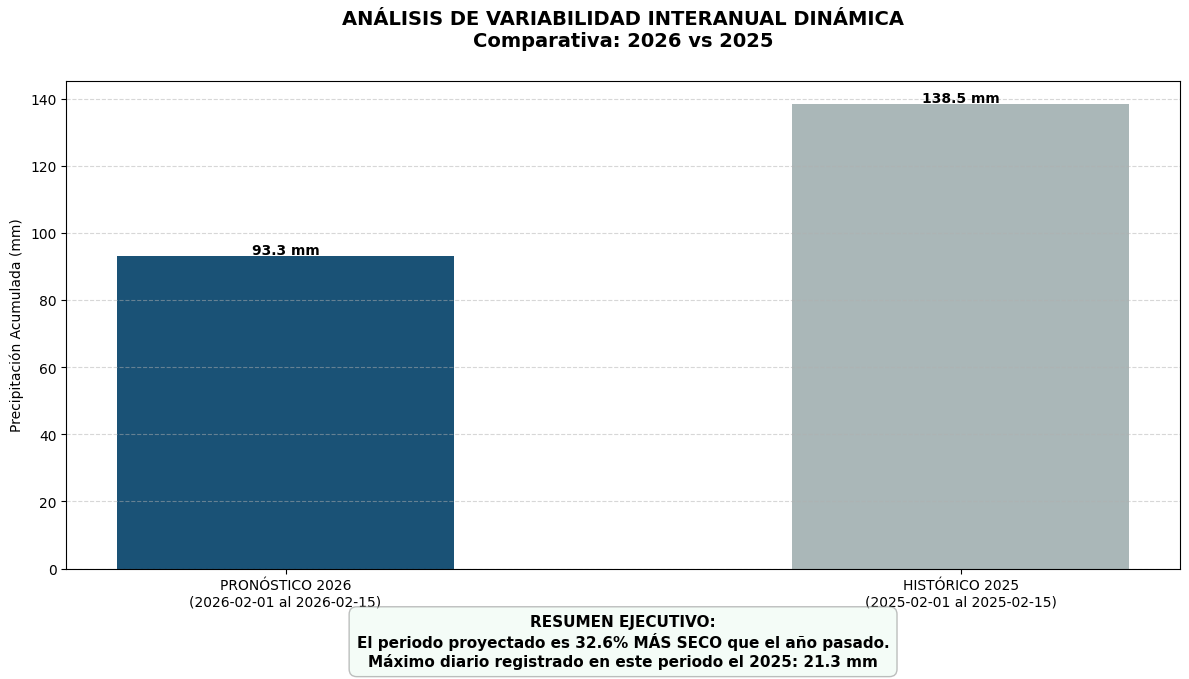

In [3]:
# =================================================================
# BLOQUE UNIVERSAL: COMPARATIVA DINÁMICA DE AÑO ANTERIOR (AÑO n vs n-1)
# =================================================================
import matplotlib.pyplot as plt
from datetime import timedelta

def generar_contexto_operativo_universal(pred_calib, estacion):
    try:
        # 1. Definir rangos de fechas del pronóstico actual (Año n)
        f_ini_actual = pred_calib.index[0]
        f_fin_actual = pred_calib.index[-1]

        # 2. Calcular automáticamente el mismo periodo del AÑO ANTERIOR (Año n-1)
        # Usamos replace(year = ...) para asegurar que sea el mismo mes/día pero un año atrás
        try:
            f_ini_anterior = f_ini_actual.replace(year = f_ini_actual.year - 1)
            f_fin_anterior = f_fin_actual.replace(year = f_fin_actual.year - 1)
        except ValueError: # Manejo para años bisiestos (29 de febrero)
            f_ini_anterior = f_ini_actual - timedelta(days=365)
            f_fin_anterior = f_fin_actual - timedelta(days=365)

        # 3. Extraer datos reales del año anterior registrados en el Excel
        hist_anterior = estacion[(estacion.index >= f_ini_anterior) & (estacion.index <= f_fin_anterior)]

        total_actual = pred_calib.sum()
        total_anterior = hist_anterior.sum()

        # 4. Cálculo de variación e indicadores
        variacion = ((total_actual - total_anterior) / total_anterior * 100) if total_anterior > 0 else 0
        max_dia_anterior = hist_anterior.max() if not hist_anterior.empty else 0

        # 5. Visualización
        fig, ax = plt.subplots(figsize=(12, 7))

        categorias = [
            f'PRONÓSTICO {f_ini_actual.year}\n({f_ini_actual} al {f_fin_actual})',
            f'HISTÓRICO {f_ini_anterior.year}\n({f_ini_anterior} al {f_fin_anterior})'
        ]
        valores = [total_actual, total_anterior]

        bars = ax.bar(categorias, valores, color=['#1a5276', '#aab7b8'], width=0.5)
        ax.set_title(f"ANÁLISIS DE VARIABILIDAD INTERANUAL DINÁMICA\nComparativa: {f_ini_actual.year} vs {f_ini_anterior.year}",
                     fontsize=14, fontweight='bold', pad=25)
        ax.set_ylabel("Precipitación Acumulada (mm)")

        # Etiquetas de valor
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f} mm',
                    ha='center', fontweight='bold')

        # Cuadro de conclusión con lógica de colores
        color_fondo = "#fdedec" if variacion > 0 else "#eafaf1"
        ax.text(0.5, -0.2,
                f"RESUMEN EJECUTIVO:\nEl periodo proyectado es {abs(variacion):.1f}% {'MÁS LLUVIOSO' if variacion > 0 else 'MÁS SECO'} que el año pasado.\n"
                f"Máximo diario registrado en este periodo el {f_ini_anterior.year}: {max_dia_anterior:.1f} mm",
                transform=ax.transAxes, ha='center', fontsize=11, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.5", fc=color_fondo, ec="gray", alpha=0.5))

        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error en comparativa interanual: {e}")

# Ejecución
generar_contexto_operativo_universal(pred_calib, estacion)

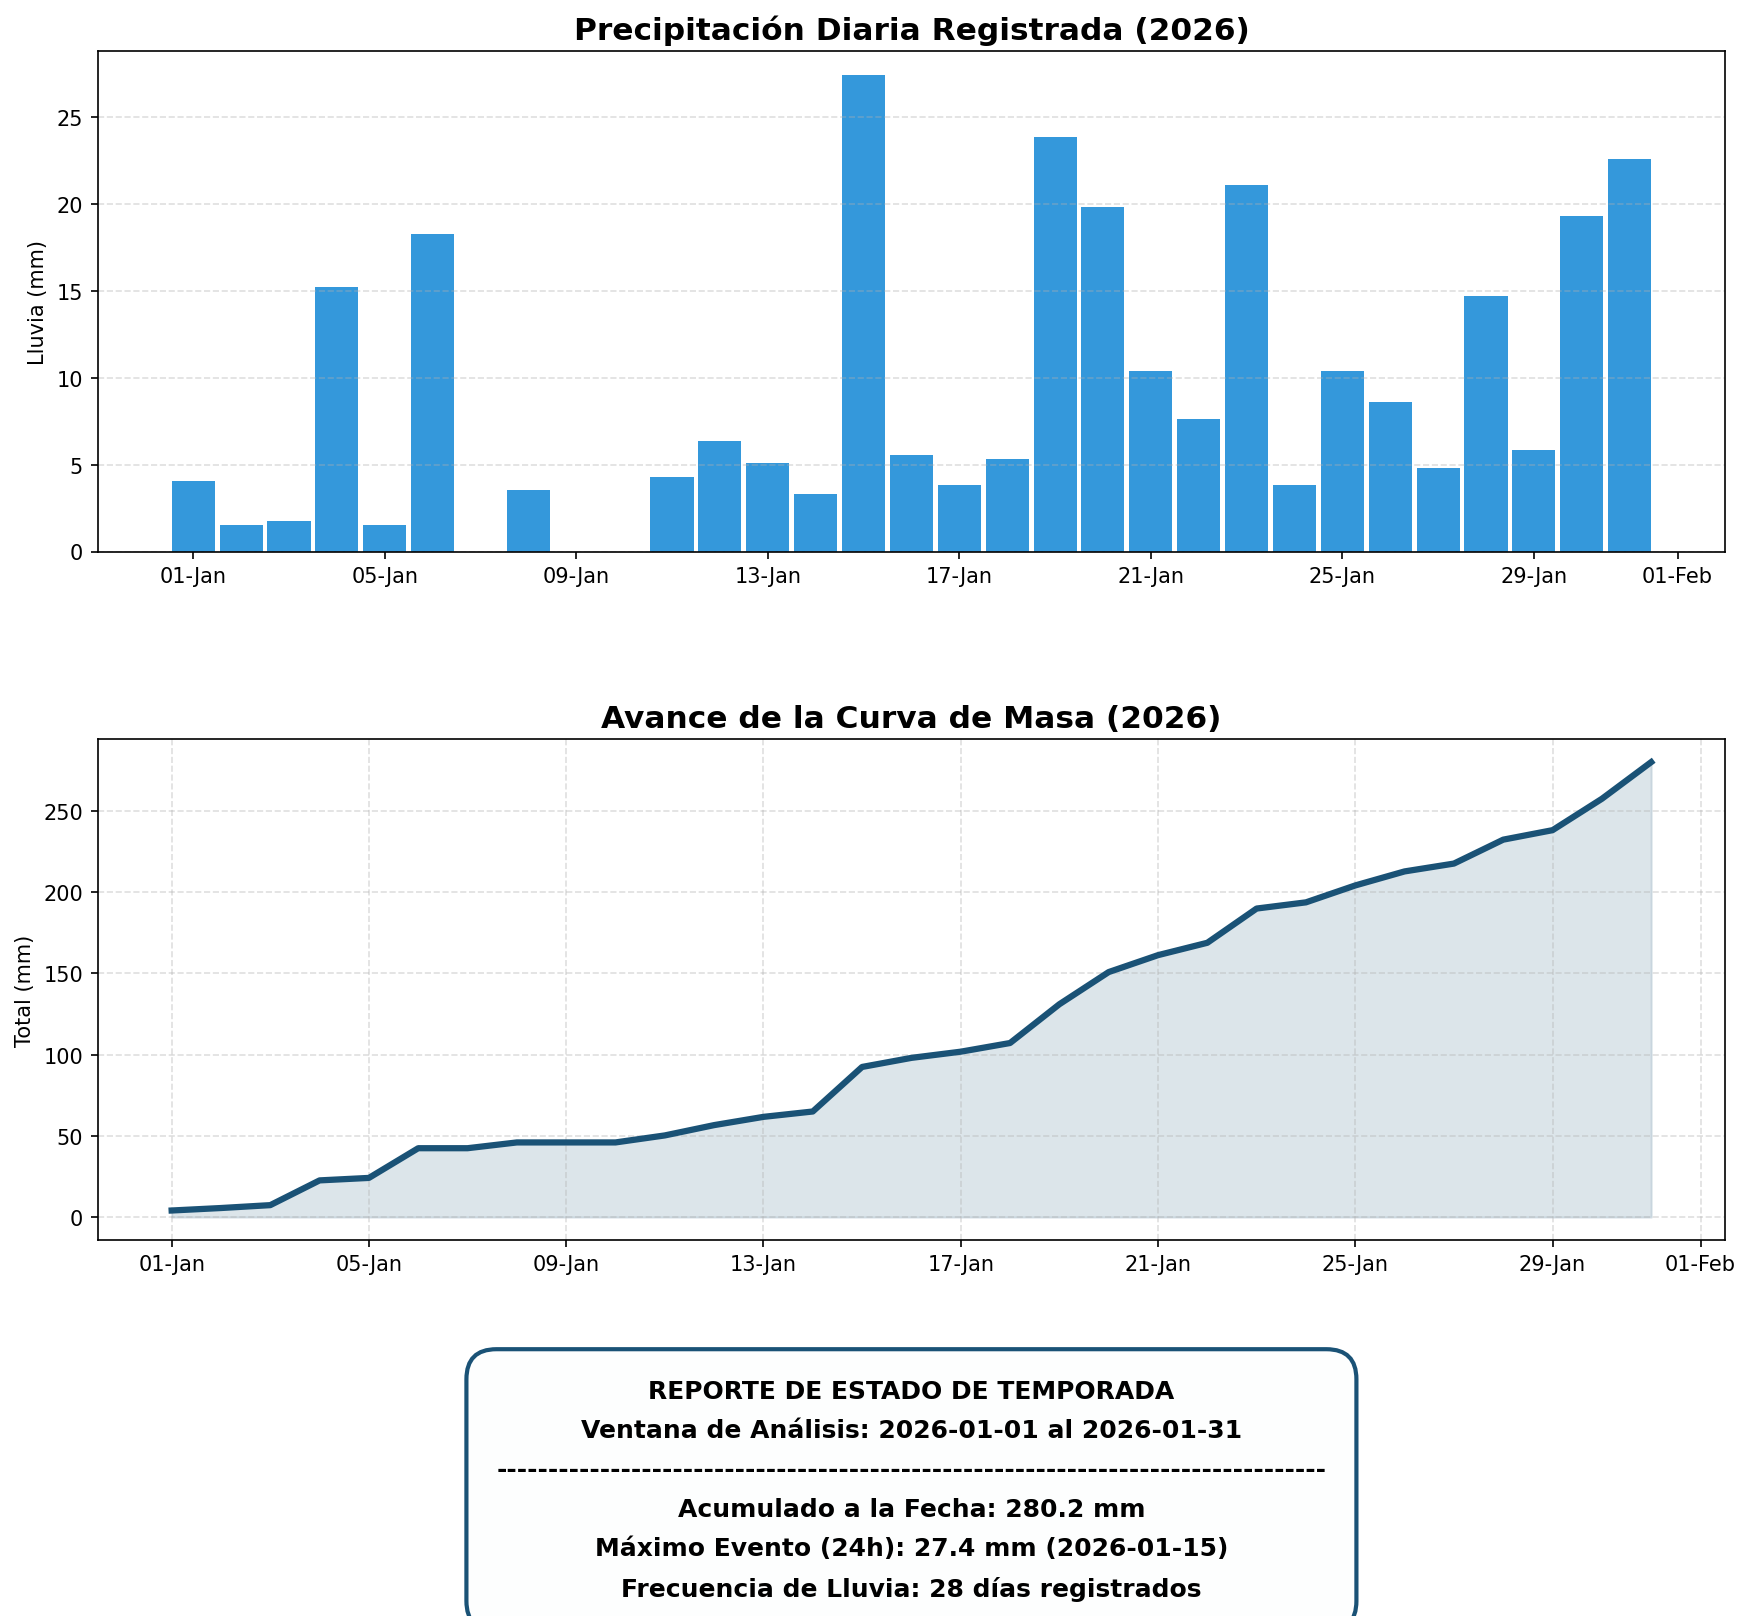

In [4]:
# =================================================================
# BLOQUE: TEMPORADA ACTUAL - EXPANSIÓN DINÁMICA (EJE X ADAPTATIVO)
# =================================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def analizar_temporada_dinamica(estacion):
    try:
        # 1. Configuración de renderizado para evitar vibración
        plt.rcParams.update({'figure.dpi': 150})

        # 2. Rango dinámico: Desde 01-Enero hasta el ÚLTIMO dato registrado
        anio_actual = datetime.now(tz_peru).year
        f_inicio = datetime(anio_actual, 1, 1).date()
        f_fin = estacion.index[-1]

        df_anio = estacion[estacion.index >= f_inicio]

        if df_anio.empty:
            print(f"Esperando registros para el año {anio_actual}...")
            return

        fig, (ax1, ax2, ax_txt) = plt.subplots(3, 1, figsize=(14, 13),
                                               gridspec_kw={'height_ratios': [1, 1, 0.25]})

        # --- GRÁFICO 1: PRECIPITACIÓN DIARIA ---
        ax1.bar(df_anio.index, df_anio.values, color='#3498db', width=0.9, edgecolor='none')
        ax1.set_title(f"Precipitación Diaria Registrada ({anio_actual})", fontsize=15, fontweight='bold')
        ax1.set_ylabel("Lluvia (mm)")

        # Formateador dinámico del eje X:
        # Matplotlib decidirá si pone días o meses según cuánto crezca el periodo
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
        ax1.grid(True, axis='y', linestyle='--', alpha=0.4)

        # --- GRÁFICO 2: PRECIPITACIÓN ACUMULADA ---
        acumulado = df_anio.cumsum()
        ax2.plot(df_anio.index, acumulado, color='#1a5276', lw=3)
        ax2.fill_between(df_anio.index, acumulado, color='#1a5276', alpha=0.15)
        ax2.set_title(f"Avance de la Curva de Masa ({anio_actual})", fontsize=15, fontweight='bold')
        ax2.set_ylabel("Total (mm)")
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
        ax2.grid(True, linestyle='--', alpha=0.4)

        # --- CUADRO: RESUMEN EJECUTIVO DINÁMICO ---
        ax_txt.axis('off')
        resumen_texto = (
            f"REPORTE DE ESTADO DE TEMPORADA\n"
            f"Ventana de Análisis: {f_inicio} al {f_fin}\n"
            f"--------------------------------------------------------------------------------\n"
            f"Acumulado a la Fecha: {df_anio.sum():.1f} mm\n"
            f"Máximo Evento (24h): {df_anio.max():.1f} mm ({df_anio.idxmax()})\n"
            f"Frecuencia de Lluvia: {(df_anio > 0.1).sum()} días registrados"
        )

        ax_txt.text(0.5, 0.5, resumen_texto, ha='center', va='center', fontsize=12,
                    fontweight='bold', linespacing=1.8,
                    bbox=dict(boxstyle="round,pad=1.2", fc="#fdfefe", ec="#1a5276", lw=2))

        plt.subplots_adjust(hspace=0.5)
        plt.show()

    except Exception as e:
        print(f"Error en análisis dinámico: {e}")

# Ejecución
analizar_temporada_dinamica(estacion)

In [5]:
# =================================================================
# BLOQUE: AUDITORÍA DE REGISTROS (CONTROL DE CALIDAD)
# =================================================================

def validar_continuidad_data(estacion):
    # La fecha esperada de último registro es ayer (siempre se registra el día cerrado)
    ayer = (datetime.now(tz_peru) - timedelta(days=1)).date()
    ultimo_registro = estacion.index[-1]

    print("-" * 50)
    print(f"REVISIÓN DE INTEGRIDAD DE DATOS:")
    print(f"• Última fecha en Excel: {ultimo_registro}")
    print(f"• Fecha esperada (ayer): {ayer}")

    if ultimo_registro < ayer:
        dias_faltantes = (ayer - ultimo_registro).days
        print(f"\n[¡ALERTA!] Faltan {dias_faltantes} días de registro en el Excel.")
        print(f"El reporte se generará, pero NO incluirá los eventos más recientes.")
    elif ultimo_registro > ayer:
        print(f"\n[OK] El Excel está actualizado incluso con datos parciales de hoy.")
    else:
        print(f"\n[OK] La base de datos está perfectamente al día.")
    print("-" * 50)

# Ejecución de auditoría
validar_continuidad_data(estacion)

--------------------------------------------------
REVISIÓN DE INTEGRIDAD DE DATOS:
• Última fecha en Excel: 2026-01-31
• Fecha esperada (ayer): 2026-01-31

[OK] La base de datos está perfectamente al día.
--------------------------------------------------
